# Preprocessing of the Data
start by importing libraries

In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
import matplotlib as plotter

Grab all filenames from the folder raw_data

In [2]:
allFiles = [f for f in listdir('raw_data') if isfile(join('raw_data', f))]

Filter to ensure only csv file names are being retrieved

In [3]:
mask = []
for file in allFiles:
    if file[0] == '.':
        mask.append(False)
    else:
        mask.append(True)

AllFiles_2 = np.array(allFiles)
files = AllFiles_2[mask]

In [4]:
files

array(['p02_n01_ready.csv', 'p02_n02_ready.csv', 'p03_n01_ready.csv',
       'p03_n02_ready.csv', 'p04_n01_ready.csv', 'p04_n02_ready.csv',
       'p05_n01_ready.csv', 'p05_n02_ready.csv', 'p06_n01_ready.csv',
       'p06_n02_ready.csv', 'p07_n01_ready.csv', 'p07_n02_ready.csv',
       'p10_n01_ready.csv', 'p10_n02_ready.csv', 'p11_n01_ready.csv',
       'p11_n02_ready.csv', 'p12_n01_ready.csv', 'p12_n02_ready.csv',
       'p13_n01_ready.csv', 'p14_n01_ready.csv', 'p14_n02_ready.csv',
       'p15_n01_ready.csv', 'p15_n02_ready.csv', 'p16_n01_ready.csv',
       'p16_n02_ready.csv', 'p17_n01_ready.csv', 'p17_n02_ready.csv'],
      dtype='<U19')

We want to create one combined dataset for training the model and to clean each night for testing
for each night round the EMNO values to three digits and create two new attributes one contains the emno value for the epoch before and the other contains the emno for the epoch after 
For the night remove rows with no emno data then data then save to CSV
For combined dataset (used for building the model) drop all rows will nulls in emno and actiwatch counts

In [5]:
frames = [] #dataframes
rounding_index = 3 #round numbers
fileNames = ['P02_N1', 'P02_N2', 'P03_N1', 'P03_N2','P04_N1','P04_N2','P05_N1', 'P05_N2','P06_N1','P06_N2','P07_N1','P07_N2','P10_N1','P10_N2','P11_N1','P11_N2','P12_N1','P12_N2','P13_N1','P14_N1',
'P14_N2','P15_N1','P15_N2','P16_N1','P16_N2','P17_N1','P17_N2']
file_index = 0
for file in files:
    df = pd.read_csv('raw_data/' + file)

    #Grab epoch above and below current row and create new columns based on these values
    for index, row in df.iterrows():
        if index == 0 or index > len(df.index)-3:
            continue
        df.at[index,'ELMO_before'] = df.at[index - 1, 'Apple Watch ENMO']
        df.at[index,'ELMO_after'] = df.at[index + 1, 'Apple Watch ENMO']


    df['Apple Watch ENMO'] = df['Apple Watch ENMO'].round(rounding_index)
    df['ELMO_before'] = df['ELMO_before'].round(rounding_index)
    df['ELMO_after'] = df['ELMO_after'].round(rounding_index)

    #For combined Dataset
    df_comb = df.copy()
    #Remove Nans of Actiwatch and EMNO read
    df_comb = df_comb.dropna(subset=['Actiwatch activity counts', 'ELMO_before', 'ELMO_after', 'ELMO_before'])
    #Add file name to combined file
    df_comb['fileName'] = fileNames[file_index]

    frames.append(df_comb)

    #For single night
    df_night = df.copy()
    df_night = df_night.dropna(subset=['Apple Watch ENMO', 'ELMO_before', 'ELMO_after'])

    #save to csv
    df_night.to_csv('derived_data/'+ fileNames[file_index] +'_filtered.csv')
    file_index += 1


In [ ]:
    Go = True
    index_start = 0
    #How long until we classify as asleep
    epochs = 20
    while Go:
        if df.iloc[index_start]['Actiware classification'] == 0:
            epochs -= 1
        else:
            epochs = 20
        
        if epochs == 0:
            Go = False
        else:
            index_start += 1

    #Start index minus last 5 minutes of sleep
    index_start -= 20

    ##Find the index to end on

    #end of sleep minus 5 minutes
    Go = True
    index_end = len(df) -1
    #How long until we classify as asleep
    epochs = 20
    while Go:
        if df.iloc[index_end]['Actiware classification'] == 0:
            epochs -= 1
        else:
            epochs = 20
        
        if epochs == 0:
            Go = False
        else:
            index_end -= 1

    #End index plus last 5 minutes of sleep
    index_end += 20

        #Filter the array to only include wanted elements
    index_starts_to_keep = list(range(index_start,index_end))
    df_filtered = df.filter(items = index_starts_to_keep, axis=0)

Combine all the nights

In [6]:
final_df = pd.concat(frames)

Remove nights P10_N1, P10_N2, P17_N2 and P15_N1 (justification below)

In [23]:
#add new dataset with removed nights
filtered_final_df = final_df[(final_df['fileName'] != 'P10_N1')&(final_df['fileName'] != 'P10_N2')&(final_df['fileName'] != 'P17_N2')&(final_df['fileName'] != 'P15_N1')&(final_df['fileName'] != 'P13_N1')]

Save combine dataset to csv

In [24]:
filtered_final_df.to_csv('derived_data/combined_dataset.csv')

# Looking for data inconsistencies

Visualise all data points

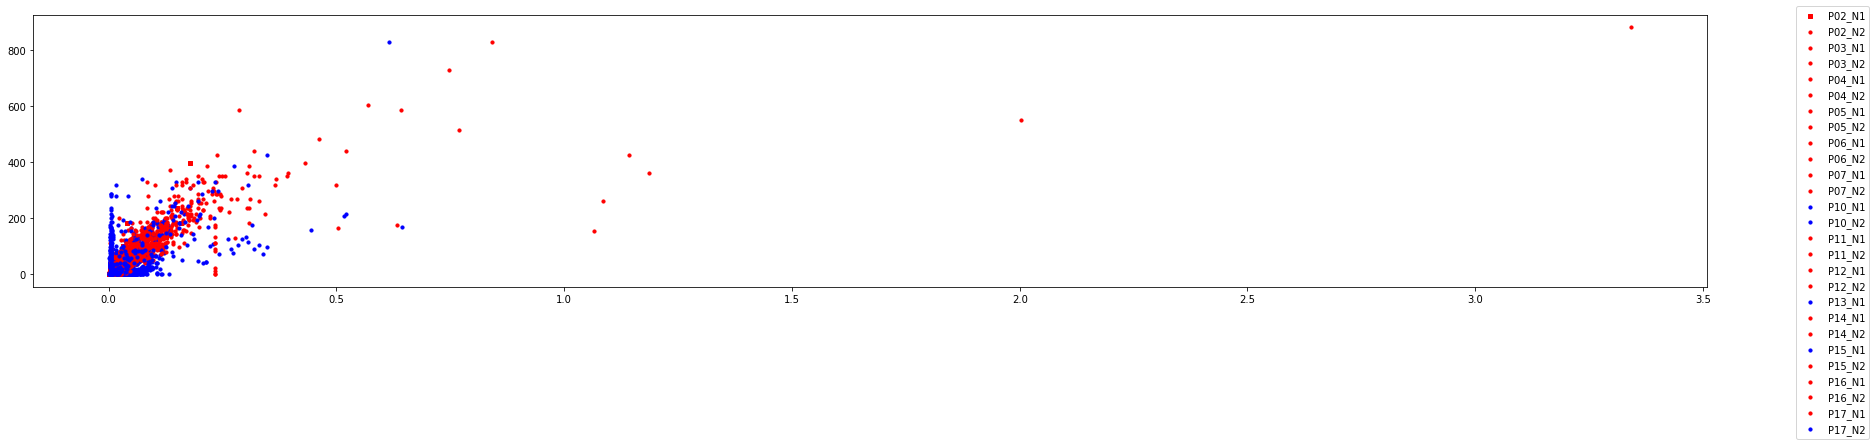

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(frames[0]['Apple Watch ENMO'], frames[0]['Actiwatch activity counts'], s=10, color="r", marker="s", label='P02_N1')
ax1.scatter(frames[1]['Apple Watch ENMO'], frames[1]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P02_N2')
ax1.scatter(frames[2]['Apple Watch ENMO'], frames[2]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P03_N1')
ax1.scatter(frames[3]['Apple Watch ENMO'], frames[3]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P03_N2')
ax1.scatter(frames[4]['Apple Watch ENMO'], frames[4]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P04_N1')
ax1.scatter(frames[5]['Apple Watch ENMO'], frames[5]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P04_N2')
ax1.scatter(frames[6]['Apple Watch ENMO'], frames[6]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P05_N1')
ax1.scatter(frames[7]['Apple Watch ENMO'], frames[7]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P05_N2')
ax1.scatter(frames[8]['Apple Watch ENMO'], frames[8]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P06_N1')
ax1.scatter(frames[9]['Apple Watch ENMO'], frames[9]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P06_N2')
ax1.scatter(frames[10]['Apple Watch ENMO'], frames[10]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P07_N1')
ax1.scatter(frames[11]['Apple Watch ENMO'], frames[11]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P07_N2')
ax1.scatter(frames[12]['Apple Watch ENMO'], frames[12]['Actiwatch activity counts'], s=10, color="b", marker="o", label='P10_N1')#whack
ax1.scatter(frames[13]['Apple Watch ENMO'], frames[13]['Actiwatch activity counts'], s=10, color="b", marker="o", label='P10_N2')#whack
ax1.scatter(frames[14]['Apple Watch ENMO'], frames[14]['Actiwatch activity counts'], s=10, color="r" , marker="o", label='P11_N1')
ax1.scatter(frames[15]['Apple Watch ENMO'], frames[15]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P11_N2')
ax1.scatter(frames[16]['Apple Watch ENMO'], frames[16]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P12_N1')
ax1.scatter(frames[17]['Apple Watch ENMO'], frames[17]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P12_N2')
ax1.scatter(frames[18]['Apple Watch ENMO'], frames[18]['Actiwatch activity counts'], s=10, color="b", marker="o", label='P13_N1')#whack
ax1.scatter(frames[19]['Apple Watch ENMO'], frames[19]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P14_N1')
ax1.scatter(frames[20]['Apple Watch ENMO'], frames[20]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P14_N2')
ax1.scatter(frames[21]['Apple Watch ENMO'], frames[21]['Actiwatch activity counts'], s=10, color="b",  marker="o", label='P15_N1')#whack
ax1.scatter(frames[22]['Apple Watch ENMO'], frames[22]['Actiwatch activity counts'], s=10,  color="r",marker="o", label='P15_N2')
ax1.scatter(frames[23]['Apple Watch ENMO'], frames[23]['Actiwatch activity counts'], s=10,  color="r",marker="o", label='P16_N1')
ax1.scatter(frames[24]['Apple Watch ENMO'], frames[24]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P16_N2')
ax1.scatter(frames[25]['Apple Watch ENMO'], frames[25]['Actiwatch activity counts'], s=10, color="r", marker="o", label='P17_N1')
ax1.scatter(frames[26]['Apple Watch ENMO'], frames[26]['Actiwatch activity counts'], s=10,  color="b",marker="o", label='P17_N2')#whack
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


Create boxplot, the boxplot will show all Emno values when actiwatch is zero. The EMNO values should only fall with a given range when compared to the other nights. If a few nights have a higher range of values this might indicate some issues with the measurements taken

In [9]:
applewatch = []
index = 1
for frame in frames:
    df1 = frame[frame['Actiwatch activity counts'] == 0 ]
    applewatch.append(df1['Apple Watch ENMO'])
    index += 1

This plot shows P10_N1, P10_N2, P13_N1 and P15_N1 have a lot of variance in the zero values when compared to the other nights. These nights will be dropped from the combined dataset

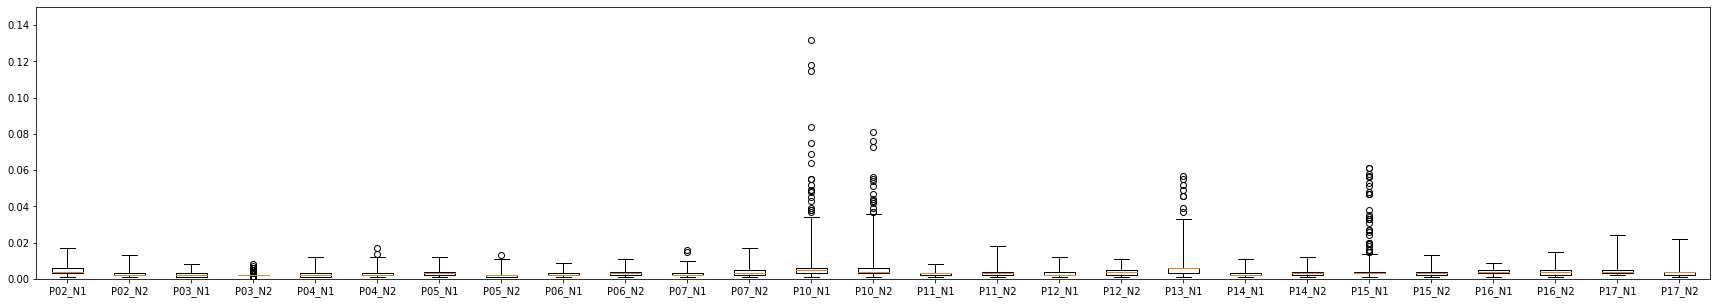

In [18]:
plt.boxplot(applewatch, whis=10)
plt.ylim(0,.15)
plt.rcParams["figure.figsize"] = (30,5)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], fileNames)
plt.show()

Create boxplot, the boxplot will show all actiwatch when EMNO is between 0 and 0.02. This range was determined by using the previous boxplot. The actiwatch values should only fall with a given range when compared to the other nights. If a few nights have a higher range of values this might indicate some issues with the measurements taken

In [20]:
actiwatch = []
index = 1
for frame in frames:
    df1 = frame[frame['Apple Watch ENMO'] < 0.02]
    actiwatch.append(df1['Actiwatch activity counts'])
    index += 1

This plot shows P10_N1, P10_N2, P15_N1 and P17_N2 have a lot of variance in the zero values when compared to the other nights. These nights will be dropped from the combined dataset

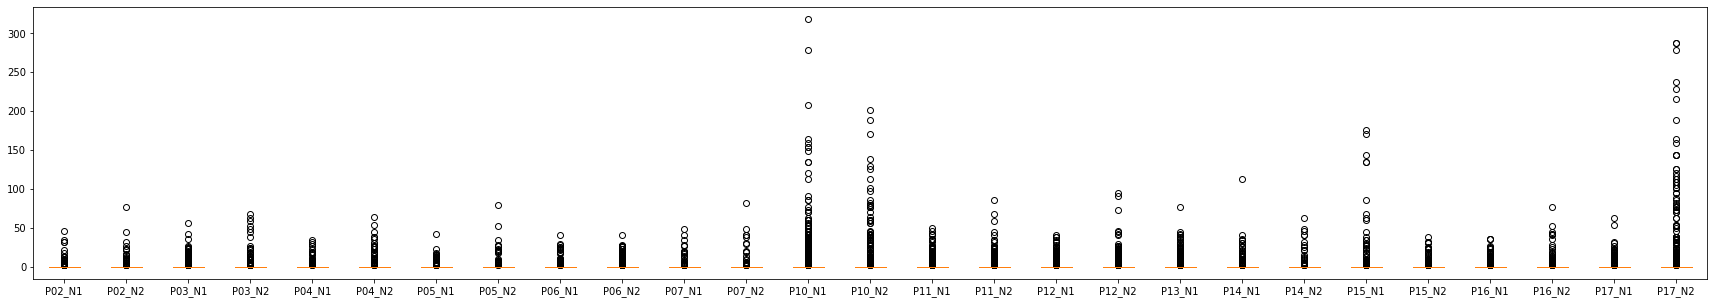

In [21]:
plt.boxplot(actiwatch, whis=1000)
plt.rcParams["figure.figsize"] = (30,5)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], fileNames)
plt.show()


In [35]:
final_df['Apple Watch ENMO'].isnull().sum()

2

In [36]:
final_df[final_df['Actiwatch activity counts'].isnull()]

,timestamp,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,fileName
8,07/01/2000 23:26:00,NaN,NaN,NaN,P05_N2
5,09/01/2000 20:45:15,NaN,NaN,NaN,P06_N2


In [19]:
#add new dataset with removed nights
filter_final_df = final_df[(final_df['fileName'] != 'P10_N1')&(final_df['fileName'] != 'P10_N2')&(final_df['fileName'] != 'P17_N2')&(final_df['fileName'] != 'P15_N1')]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4fd78f3908>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4fd76dfd30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4fd78f33c8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4fe0031278>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4fe0031ba8>],
 'means': []}

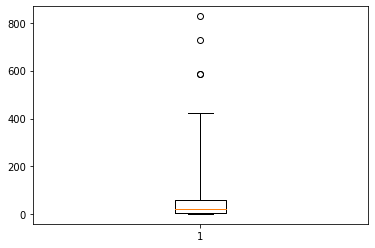

In [212]:
filter_final_df_drops = filter_final_df.dropna()
filter_final_df_drops = filter_final_df_drops[filter_final_df_drops['Actiwatch activity counts'] != 0 ]
plt.boxplot(filter_final_df_drops['Actiwatch activity counts'], whis = 10)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4fe0398908>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4fe0398b38>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4fe0398cc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4fe043c668>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4fe043c6d8>],
 'means': []}

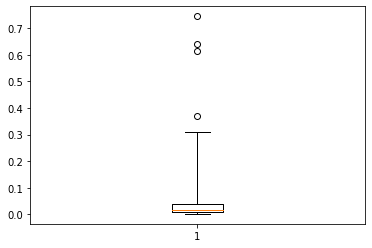

In [213]:
filter_final_df_drops = filter_final_df.dropna()
filter_final_df_drops = filter_final_df_drops[filter_final_df_drops['Actiwatch activity counts'] != 0 ]
plt.boxplot(filter_final_df_drops['Apple Watch ENMO'])